## C S 363D HW 8

# Clustering with K-means and DBSCAN

## Ana Williams & Fronrich Puno

For this week's homework we are going explore two clustering methods:

  - K-Means, and
  - DBSCAN
  
As we discussed in lecture, k-means creates clusters based on a distance measure, and DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Part 1 : K-Means

In the first half of the homework, we will implement the Algorithm 7.1 "Basic K-means", and apply that algorithm to a small data set provided with the assignment in the `data_kmeans.csv` file. We will build up some helper functions along the way, test them, and put it all together to apply to our small example data set. 

In [2]:
# loading in our toy data
df_kmeans = pd.read_csv('data_kmeans.csv')

## Q1.1 - Write a function that returns `k` random rows from a data frame

To initialize the centroids, we pick `k` random points from a data frame.  Write a function `init_centroids( df_data, k )` that accepts two parameters: a data frame `df_data`, and an integer `k`, and returns the initial centroids for our k-means algorithm.  Note, we want the indices of the returned data frame to range from 0 - (k-1) so that we can use these as the centroid labels.  Use [pandas sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method, and pass it the value of $42$ for `random_state`. 

In [3]:
def init_centroids( df_data, k ):
    # your code here
    df_ret = pd.DataFrame(columns=['x', 'y'])
    df_samp = df_data.sample(k, random_state = 42).copy()
    
    # create a dictonary with the unique values as keys
    # keys should be in the same order that they are in within cent_val
    centroid_dict = {}
    
    zero_index = 0
    for index, row in df_samp.iterrows():
        centroid_dict[zero_index] = {'x': row['x'], 'y': row['y']}
        zero_index += 1
        
    # sniff
    # print(centroid_dict)
    
    zero_index = 0
    for key, val in centroid_dict.items():
        df_ret.loc[zero_index, 'x'] = centroid_dict[key]['x']
        df_ret.loc[zero_index, 'y'] = centroid_dict[key]['y']
        zero_index += 1
    
    return df_ret

In [4]:
# Testing our init centroid function
df_centroids = init_centroids( df_kmeans, 7 )
df_centroids

,x,y
0,-0.633437,0.488756
1,-0.597736,0.632194
2,-0.635867,0.166613
3,-0.539351,-0.875532
4,-0.588597,0.293062
5,-0.127985,-0.136639
6,0.342579,0.211717


## Q1.2 - Write a function to assign every row in a data frame to a centroid 

Write a function, `assign_to_centroid`, that accepts two parameters: a data frame, `df_data`, that represents our data to be clustered, and the data frame, `df_centroids`, which is of length `k` and contains the current centroids for our clusters.  The functions returns a series of the same length of `df_data` that contains the index of the closest centroid in `df_centroid`.  Use Euclidean distance as your distance measure. 

For example, if a row of data contained the data point $(100,123)$ and the three centroids were in a data frame that had the following information:

  - Index 0 : (34,34)
  - Index 1 : (0,1)
  - Index 2 : (83,99)

The `assign_to_centroid` function would assign the index $2$ to that row of data. 

In [5]:
# get euclidan distance
def getDist(point_1, point_2):
    p_1 = point_1.to_numpy()
    p_2 = point_2.to_numpy()
    return np.linalg.norm(p_1 - p_2)

In [6]:
# sniff test
clustered = df_kmeans.sample()
centroid = df_centroids.sample()
test =  getDist(clustered, centroid)
test

1.027853426080583

In [7]:
def assign_to_centroid( df_data, df_centroids ):
    # find the distance between x,y in df_data and df_centroids
    # determine the closest centroid and mark it's index in a series
    # calculating Euclidean distance 
    # using linalg.norm() 
    # dist = np.linalg.norm(point1 - point2)
    
    # series we will be appending to
    centroid_series = []
    for index, row in df_data.iterrows():

        # distingish constants
        index_cls = index
        row_cls = row
        
        # initial values to compare to
        min_dist = getDist(row_cls, df_centroids.sample())
        min_index = 0
        
        for index, row in df_centroids.iterrows():
            
            # distingish constants
            index_cen = index
            row_cen = row
            
            curr_dist = getDist(row_cls, row_cen)
            if curr_dist <= min_dist:
                min_dist = curr_dist
                min_index = index_cen
        centroid_series.append(min_index)
    return pd.Series(centroid_series)

In [8]:
# Check how many data points were assigned to each centroid
s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
cent_val = s_centroid_assignment.value_counts()
cent_tot = cent_val.sum()
print(cent_val)
print(cent_tot)

6    126
1     94
3     71
5     58
0     53
2     26
4     22
dtype: int64
450


## Q1.3 - Write a function that recomputes the centroids

Write a function `compute_centroids` that takes two parameters: the data frame, `df_data` containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, `s_centroid_assignment`. The function will return the a data frame containing the centroids (mean) value for each unique centroid. 

Note that the indices in the returned data frame should correspond to the unique values in `s_centroid_assignment`.  For example, if I found the mean value of df_data using the slice corresponding to `s_centroid_assigment == 2`, then the centroid should be in the returned data frame at `.iloc[2]`. 


In [9]:
def compute_centroids( df_data, s_centroid_assignment ):
    # your code here
    # for each centroid, recalculate the mean for each x, y based on the points associated with it in df_data
    df_centroid_assoc = pd.concat([s_centroid_assignment.to_frame('centroid'), df_data], axis = 1)
    
    # sniff
    # print(df_centroid_assoc)
    
    # get the value counts to divide by later
    centroid_val = s_centroid_assignment.value_counts()
    
    # create a dictonary with the unique values as keys
    # keys should be in the same order that they are in within cent_val
    centroid_dict = {}
    
    # iterate through centroid_val, get the index and set x, y to 0, 0
    for key, val in centroid_val.items():
        centroid_dict[key] = {'x': 0, 'y': 0}
    
    # sniff
    # print(centroid_dict)
    
    # for eah row, add to x, y value for each dict[centroid]
    for index, row in df_centroid_assoc.iterrows():
        centroid_dict[row['centroid']]['x'] += row['x']
        centroid_dict[row['centroid']]['y'] += row['y']
        
    # sniff
    # print(centroid_dict)
    
    # divide each x,y by the number of rows per each centroid to get the mean cords
    for key, val in centroid_val.items():
        centroid_dict[key]['x'] /= val
        centroid_dict[key]['y'] /= val
        
    # sniff
    # print(centroid_dict)
    
    df_return = pd.DataFrame(columns=['x', 'y'])
    
    # convert dict to dataframe
    index = 0
    for key, val in centroid_val.items():
        df_return.loc[index, 'x'] = centroid_dict[key]['x']
        df_return.loc[index, 'y'] = centroid_dict[key]['y']
        index += 1
    
    return df_return 

In [10]:
# Test it out
df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids

,x,y
0,0.523364,0.238569
1,-0.721574,0.708343
2,-0.696694,-0.699028
3,-0.102365,-0.188876
4,-0.715983,0.500552
5,-0.738268,-0.11383
6,-0.546913,0.321364


## Q1.4 - Write a function that compares two centroid data frames

The stopping criterion for k-means is when our centroids have not moved since the last iteration.  Write a function `compare_centroids` that is given 2 centroid data frames, `df_centroid_a`, and `df_centroid_b` as parameters and returns `True` or `False` indicating if the centroids at each unique index in the data frame are equal. Use the [equals](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.equals.html) method to compare equality of pandas Series objects. 

In [11]:
def compare_centroids( df_centroid_a, df_centroid_b ):
    return df_centroid_a.equals(df_centroid_b)

In [12]:
# Test it out, should print True followed by False
print(compare_centroids( df_new_centroids, df_new_centroids ))
print(compare_centroids( df_new_centroids, df_centroids ))

True
False


## Q1.5 - Write a function that implements k-means

Write a function, `k_means`, that takes in as parameters 2 values, a data frame with values to cluster, `df_data`, and the number of clusters to form, `k`.  The function should return a series of data of the same length as `df_data` that contains the cluster assignment (an integer from 0 to (k-1)) for each row of data.  Use the helper functions defined in the prior questions. 

In [13]:
def k_means_iteration(df_centroid_updated, df_data, k, debug):
    # get centroids
    df_centroid = df_centroid_updated
    
    # assign points
    s_centroid_assignment = assign_to_centroid(df_data, df_centroid)
    
    # re-calculate mean
    df_centroid_mean = compute_centroids(df_data, s_centroid_assignment)
    
    # compare
    reiterate = not compare_centroids(df_centroid, df_centroid_mean)
    
    if debug:
        print(reiterate)
    
    return (df_centroid_mean, s_centroid_assignment, reiterate)

In [14]:
def k_means( df_data, k ):
    # your code here
    # get centroids
    df_centroid = init_centroids( df_data, k )
    
    # sniff
    # print(df_data)
    
    # for my sanity
    print('running...')
    
    # 1st round
    df_centroid, s_centroid_assignment, reiterate = k_means_iteration(df_centroid, df_data, k, 0)
    
    while reiterate:
        df_centroid, s_centroid_assignment, reiterate = k_means_iteration(df_centroid, df_data, k, 0)

    print('done!')
    
    return s_centroid_assignment

In [15]:
# Call k_means with k = 5 to test
s_cluster_assignment = k_means(df_kmeans, 5)
s_cluster_assignment.value_counts()

running...
done!


0    178
1     89
2     74
3     63
4     46
dtype: int64

## Q1.6 - Plot the results

Plot the points in the `df_kmeans` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`).  Label your axes, and give the plot a title. 

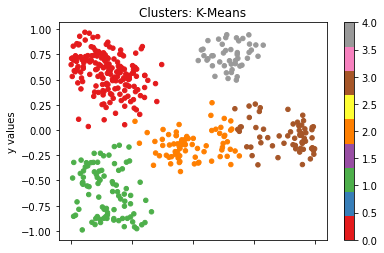

In [16]:
# Plot each cluster
# your code here
df_kmeans['Cluster'] = s_cluster_assignment
df_kmeans.plot.scatter( x='x', y='y', c=df_kmeans['Cluster'], colormap='Set1')
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Clusters: K-Means')
plt.show()

In [17]:
df_kmeans = df_kmeans.drop(['Cluster'], axis = 1)

# Part 2 : DBSCAN

## Q2.1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. 

running...
done!


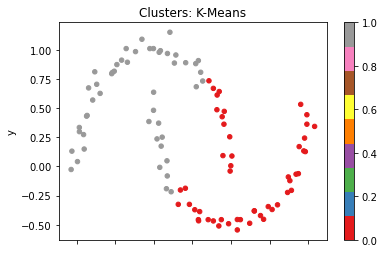

In [18]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Call k_means with k = 2
s_cluster_assignment = k_means( df_dbscan, 2)

# Plot each cluster
# your code here
df_dbscan['Cluster'] = s_cluster_assignment
df_dbscan.plot.scatter( 'x', 'y', c=df_dbscan['Cluster'], colormap='Set1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Clusters: K-Means')
plt.show()

In [19]:
df_dbscan = df_dbscan.drop(['Cluster'], axis = 1)

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [20]:
def range_query( df_data, q_index, eps ):
    # your code here
    Neighbors = pd.DataFrame()
    for index in range(len(df_data)):
        dist = (df_data.loc[q_index]['x'] - df_data.loc[index]['x'])**2 + (df_data.loc[q_index]['y'] - df_data.loc[index]['y'])**2
        dist = np.sqrt(dist)
        if (dist <= eps):
            Neighbors = Neighbors.append(df_data.loc[index], ignore_index = False)
    return Neighbors

In [21]:
df_n = range_query( df_dbscan, 0, 0.1 )
df_n

,x,y
0,1.08,-0.544
6,1.12,-0.456
10,1.08,-0.455


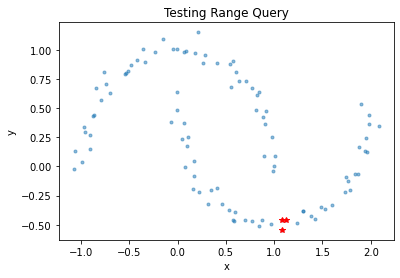

In [22]:
# Test it out
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN.

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. 

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [23]:
def dbscan( df_data, eps, min_pts ):
    NOISE_LABEL = 0
    NumClust = 0
    # your code here
    df_data['Cluster'] = -1 #creating col to assign cluster values and initalizing to -1
    
    for index in range(len(df_data)): #looping through all points
        
        if df_data.loc[index]['Cluster'] != -1: #check if cluster has already been assigned
            continue  
            
        neighbors = range_query(df_data, index, eps) #grabbing neighbors for that point
        
        if len(neighbors) < min_pts: #can this be a cluster?  
            df_data.loc[index, 'Cluster'] = NOISE_LABEL #label as noise 
            continue
            
        NumClust += 1 #found cluster incriment value to create cluster 
        df_data.loc[index, 'Cluster'] = NumClust #labeling cluster
        
        indexes = [] #make array to hold indexes of neighbor points
        
        for i, data in neighbors.iterrows(): #looping through and adding indexes
            indexes.append(i) 
        
        index2 = 0 #value to track where at in list of neighbors
        
        while index2 < len(indexes): #looping through set of neighbors 
            i = indexes[index2]
            index2 = index2 + 1 #incrimenting index 2
            
            if df_data.loc[i]['Cluster'] == NOISE_LABEL: #is it labeled as noise? 
                df_data.loc[i, 'Cluster'] = NumClust #change label to cluster value
                
            if df_data.loc[i]['Cluster'] != -1: #if already labeled move on
                continue 
                
            df_data.loc[i, 'Cluster'] = NumClust #label point as part of cluster 
            
            neighbors = range_query(df_data, i, eps) #find neighbors of this point
            
            if len(neighbors) >= min_pts: #if able to add to cluster add to indexs
                
                for ind, data in neighbors.iterrows(): #loop through these points
                    
                    if ind not in indexes: #if not in set add to it 
                        indexes.append(ind)
    res = df_data['Cluster']
    df_data = df_data.drop(['Cluster'], axis = 1)
    return res

In [24]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

1    49
2    48
0     3
Name: Cluster, dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

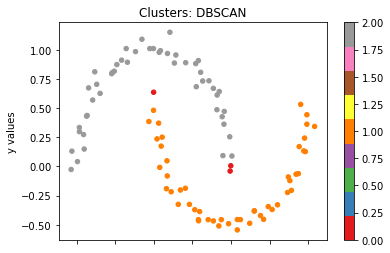

In [25]:
# Plot each cluster
# your code here
df_dbscan['Cluster'] = s_cluster_assignment
df_dbscan.plot.scatter( 'x', 'y', c=df_dbscan['Cluster'], colormap='Set1')
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Clusters: DBSCAN')
plt.show()

In [26]:
df_dbscan = df_dbscan.drop(['Cluster'], axis = 1)

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

In [27]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN
# your code here
clusters = DBSCAN(eps=0.23, min_samples=6).fit(df_dbscan)
labels = clusters.labels_
match = 0;
for index in range (len(labels)):
    if labels[index] == s_cluster_assignment[index] - 1:
        match += 1
match = match / len(labels)
print(match)

1.0


In [28]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        1,  0, -1,  1,  0,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  1,  0,  1,  0, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

Scikit_learn's DBSCAN matched our outcome perfectly. The main difference is they used -1 for noise instead of zero and this shifted the numerical value assigned to clusters. Scikit_learn's is also more effiecent in terms of compile time making it the more time effective choice. 